<a href="https://colab.research.google.com/github/Rafiryd/regresi-kecocokan-harga-rumah/blob/rafiryd/02_regression_analysis_house_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House price prediction using Linear Regression



House price prediction using a linear regression model is a classic example of applying machine learning to real-world problems. In this analysis, I want to understand how we can apply linear regression to predict house prices. First I assessed the data quality, handling missing values, and addressing outliers followed by various visualizations. To ensure the model's efficiency, I used various feature selection techniques, e.g., Correlation Analysis, Backward Feature Elimination, and Mutual Information Regression.



## Linear Regression
Linear regression is a supervised learning technique used for predicting a continuous output (like house prices) based on input features (like square footage, number of bedrooms, etc.). It models the relationship between the input features and the output using a linear equation.

The goal of linear regression is to find the best-fitting linear relationship between the independent variables (features) and the dependent variable (house price). The equation can be represented as:

$Price = w_0 + w_1 * Feature_1 + w_2 * Feature_2 + ... + w_n * Feature_N$

* $Price$: Predicted house price.
* $Feature_1, Feature_2, ... Feature_N$: Independent variables.
* $w_0, w_1, w_2, ... w_n$: Coefficients (weights) associated with each feature.

The coefficients are determined during the training process to minimize the difference between predicted prices and actual prices in the training dataset.

## Data set

The data comes from a Kaggle competition named “House Prices: Advanced Regression Techniques”. It contains 1460 training data points and 80 features that might help us predict the selling price of a house. The description of each data field can be found at: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data


In [4]:
#load the libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import time
import warnings

from datetime import datetime
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNetCV, ElasticNet
from sklearn.feature_selection import SelectKBest, RFE,RFECV, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Load the data

In [5]:
# load the data
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")


In [6]:
train_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [7]:
print("Shape of training data:", train_df.shape)
print("Shape of testing data:",test_df.shape)

Shape of training data: (1460, 81)
Shape of testing data: (1459, 80)


The dataset contains both categorical and numerical attributes.

In [8]:
len(train_df.columns)

81

In [9]:
print("No of numerical feileds", len(train_df.select_dtypes(exclude=[int]).columns))
print("No of categorical feileds", len(train_df.select_dtypes(exclude=[object]).columns))

# Integer type columns in the data
train_df.select_dtypes(exclude=[int]).columns

No of numerical feileds 46
No of categorical feileds 38


Index(['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [10]:
train_df.select_dtypes(exclude=[object]).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [75]:
train_df['OverallQual'].unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  2])

All together there are 81 unique attributes in the training data set. However, some of them have been identified as int and object type, e.g., 'LotFrontage', 'MasVnrArea'. This can become a very large feature space with one-hot encoding for categorical data. Let's do some data preprocessing and feature selection to reduce the feature space.

In [11]:
# Check for duplicate columns
col_list=train_df.columns
if len(col_list) == len(set(col_list)):
    print("There are no duplicate columns")

There are no duplicate columns


## Data Preprocessing

Prior to any feature selection, we need to preprocess the data to get it in a form suitable for analysis.

### Drop the missing values

Here, we check for the percentage of missing values in each attribute column.

In [12]:
# Drop columns with more than 80% of missing values

missing_val_df=(train_df.isnull().sum() / len(train_df)).sort_values(ascending=False)
missing_features = missing_val_df[missing_val_df > 0.80].index
train_df.drop(missing_features, axis=1, inplace=True)

train_df["FireplaceQu"].fillna("NA", inplace = True)

(train_df.isnull().sum() / len(train_df)).sort_values(ascending=False)

LotFrontage     0.177397
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
                  ...   
BsmtUnfSF       0.000000
TotalBsmtSF     0.000000
MSSubClass      0.000000
HeatingQC       0.000000
SalePrice       0.000000
Length: 77, dtype: float64

In [13]:
# Drop the rest of the rows with null values
train_df.dropna(inplace = True)

In [14]:
train_df.isnull().values.any()

False

### Drop the zero variance columns

In [15]:
# remove coloumns with constant values
train_df = train_df.loc[:, (train_df != train_df.iloc[0]).any()]
print(train_df.shape)

(1094, 76)


Then let's look at the unique values in each categorical column of our training data.

In [16]:
# the unique categorical values in each categorical colomn
for col in train_df.select_dtypes(exclude=[int]):
    print(col, ":" ,train_df[col].unique())

MSZoning : ['RL' 'RM' 'C (all)' 'FV' 'RH']
LotFrontage : [ 65.  80.  68.  60.  84.  85.  75.  51.  50.  70.  91.  66. 101.  57.
  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  52. 100.  24.  89.
  63.  76.  72.  81.  95.  69.  21.  32.  78. 121. 122.  40.  73.  77.
  94. 105.  34.  90.  55.  88.  82.  71. 120. 107.  92. 134.  86.  62.
 141.  97.  54.  64.  41.  79. 174.  99.  83.  43. 103.  93.  30. 129.
 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.  36.  56. 102.
  38. 109. 130.  67.  53. 137.  58. 106. 104.  42.  39. 144.  45. 114.
 128. 149. 313. 168. 182. 160. 152. 124.  46.]
Street : ['Pave' 'Grvl']
LotShape : ['Reg' 'IR1' 'IR2' 'IR3']
LandContour : ['Lvl' 'Bnk' 'Low' 'HLS']
LotConfig : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope : ['Gtl' 'Mod' 'Sev']
Neighborhood : ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'OldTown'
 'BrkSide' 'Sawyer' 'NridgHt' 'SawyerW' 'NAmes' 'IDOTRR' 'MeadowV'
 'Timber' 'StoneBr' 'ClearCr' 'Gilbert' 'Edwards' 'NWAmes'

As you can see some of the columns actually contain numerical values, so we can convert them to int type. However, even though 'GarageYrBlt' seems numerical, since it represents a year I would keep it as a categorical variable.

In [17]:
# convert categorical to numerical colomns
train_df = train_df.astype({"LotFrontage": int, "MasVnrArea": int})

In [18]:
# similarly convert numerical to categorical colomns
train_df = train_df.astype({"YrSold": object, "GarageYrBlt": object, "YearBuilt": object, "YearRemodAdd": object})

In [49]:
from scipy import stats

# Select only numeric columns for z-score calculation
numeric_columns = train_df.select_dtypes(include=[np.number])

# Calculate z-scores for numeric columns
z_scores = np.abs(stats.zscore(numeric_columns))
outliers = (z_scores > 3).all(axis=1)

# Filter the rows containing outliers
train_df = train_df[~outliers]
train_df


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,Reg,Lvl,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,Reg,Lvl,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,IR1,Lvl,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,IR1,Lvl,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,IR1,Lvl,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62,7917,Pave,Reg,Lvl,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85,13175,Pave,Reg,Lvl,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66,9042,Pave,Reg,Lvl,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68,9717,Pave,Reg,Lvl,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


## Correlation analysis

Correlation analysis is a statistical technique used to quantify the degree of association or relationship between two or more variables in a dataset. It helps determine whether and to what extent changes in one variable correspond to changes in another. Correlation analysis provides insights into how variables move together or in opposite directions, which is important for understanding patterns and making predictions.

### Correlation among the features

Here we used the '**Pearson Correlation Coefficient**', the most common form of correlation analysis is Pearson's correlation coefficient, which measures the linear relationship between two continuous variables. It assumes that the relationship between the variables is approximately linear and that the data follows a normal distribution.

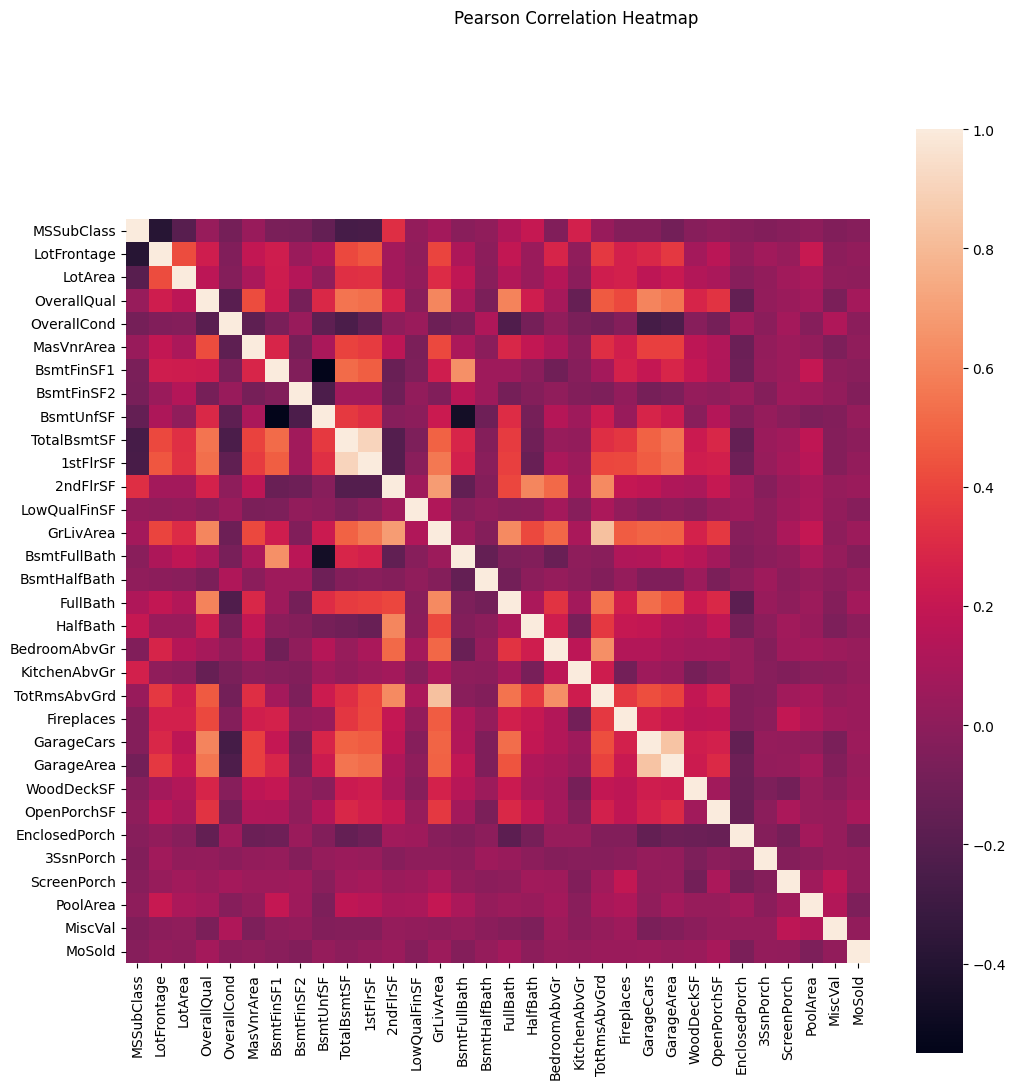

In [50]:
# Check for correlation with the Numeric features
# corr() function only calculates the correlation coefficients between numerical columns.

train_df_nid = train_df.drop(['Id'],axis=1)
pd.set_option('display.precision', 2)
plt.figure(figsize=(12,12))

sns.heatmap(train_df_nid.drop(['SalePrice'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show()

In [51]:
# Create correlation matrix
corr_matrix = train_df_nid.drop(['SalePrice'],axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# select one feature from the highly correlated features, threshold 0.6
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

print(to_drop)

# drop the selected feattures that are correlated with anothoer feature
train_df_nid.drop(to_drop, axis=1, inplace=True)

['1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']


### Correlation with the target Variable

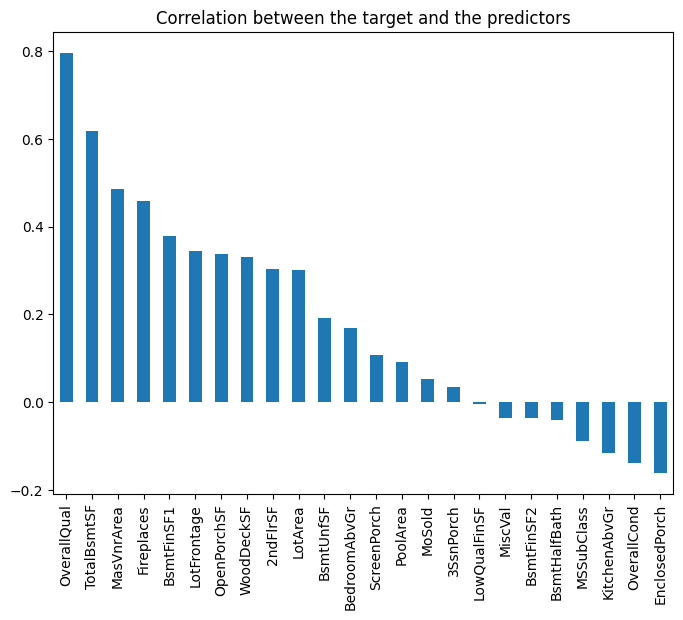

In [52]:
corr_with_tot_count = train_df_nid.corr()["SalePrice"].sort_values(ascending=False)

plt.figure(figsize=(8,6))
corr_with_tot_count.drop("SalePrice").plot.bar()
plt.title('Correlation between the target and the predictors')
plt.show()

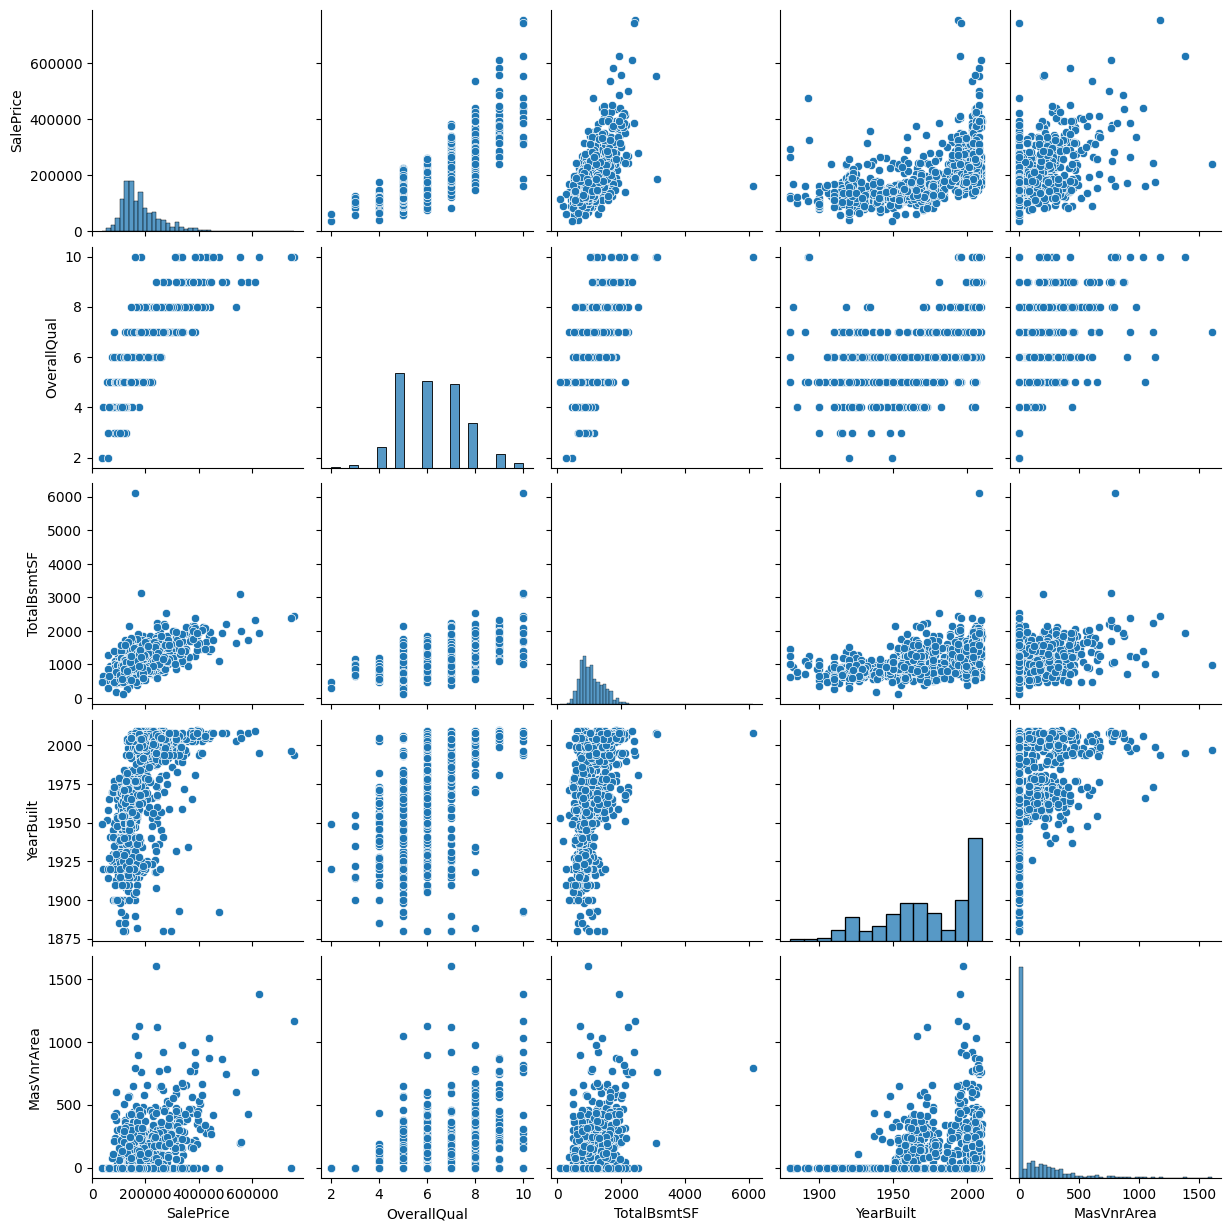

In [53]:
sns.pairplot(train_df_nid[['SalePrice', 'OverallQual', 'TotalBsmtSF', 'YearBuilt','MasVnrArea']])
plt.show()

In [54]:
# remove features that has correlation smaller than 0.2 these since there is low correlation to the target variable
post_corr = corr_with_tot_count[corr_with_tot_count > 0.2].index.tolist()
print(post_corr)

# capture the data of selected features
df_bs_cont = train_df[post_corr]
df_bs_cont.head(3)

['SalePrice', 'OverallQual', 'TotalBsmtSF', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'OpenPorchSF', 'WoodDeckSF', '2ndFlrSF', 'LotArea']


,SalePrice,OverallQual,TotalBsmtSF,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,OpenPorchSF,WoodDeckSF,2ndFlrSF,LotArea
0,208500,7,856,196,0,706,65,61,0,854,8450
1,181500,6,1262,0,1,978,80,0,298,0,9600
2,223500,7,920,162,1,486,68,42,0,866,11250


### Distribution of the target variable

Text(0.5, 1.0, 'Distribution of the target variable - SalePrice')

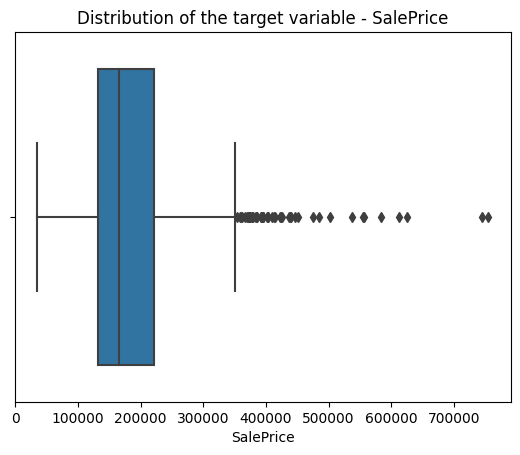

In [55]:
# Box-Plot
sns.boxplot(x=train_df['SalePrice'])
plt.title("Distribution of the target variable - SalePrice")

Text(0.5, 1.0, 'Distribution of the target variable - SalePrice')

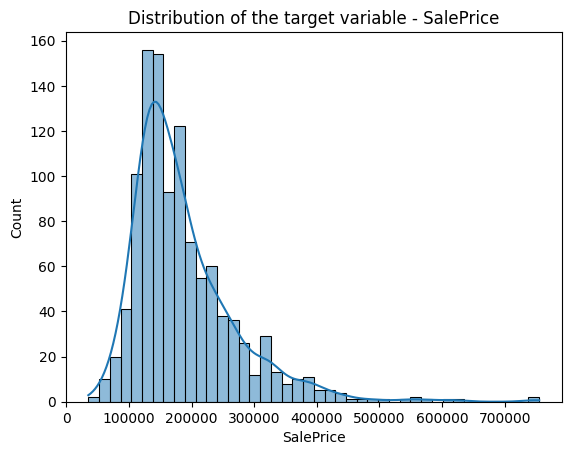

In [56]:
sns.histplot(x= "SalePrice",data=train_df, kde=True)
plt.title("Distribution of the target variable - SalePrice")

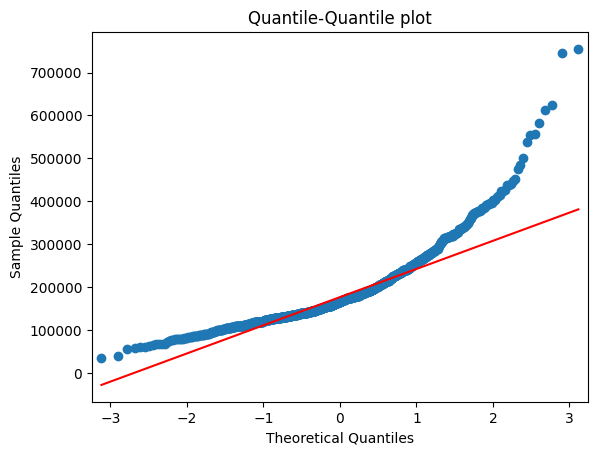

In [57]:
sm.qqplot(train_df['SalePrice'], line='q')
plt.title("Quantile-Quantile plot")
plt.show()

As the above graphs explain, our target variable 'SalePrice' does not follow a normal distribution. It is rightly skewed. Let's try the log formation of the data to see if we can transform the target variable to follow a normal distribution.

Text(0.5, 1.0, 'Distribution of the transformed target variable - log(SalePrice)')

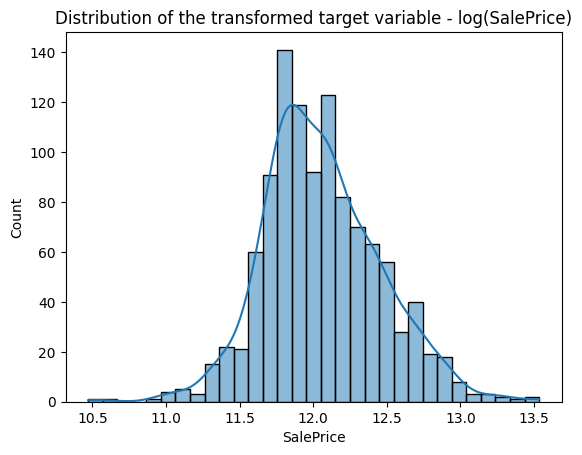

In [58]:
sns.histplot(x= np.log(train_df['SalePrice']), kde=True)
plt.title("Distribution of the transformed target variable - log(SalePrice)")

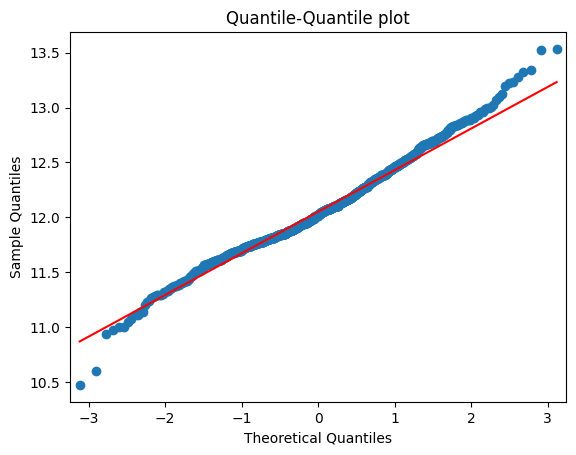

In [59]:
sm.qqplot(np.log(train_df['SalePrice']), line='q')
plt.title("Quantile-Quantile plot")
plt.show()

Great, now the distribution of our target variable follows a normal distribution. There are a few outliers, but let's not worry about that for now.

In [60]:
# combine the selected numerical features with the categorical data
train_df_new= pd.concat([train_df.select_dtypes(include=['object']),
                       df_bs_cont],axis=1)
train_df_new.describe()

,SalePrice,OverallQual,TotalBsmtSF,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,OpenPorchSF,WoodDeckSF,2ndFlrSF,LotArea
count,1094.00,1094.00,1094.00,1094.00,1094.00,1094.00,1094.00,1094.00,1094.00,1094.00,1094.00
mean,187033.26,6.25,1099.56,109.86,0.61,448.19,70.76,46.95,94.34,356.54,10132.35
std,83165.33,1.37,415.85,190.67,0.63,468.73,24.51,64.82,122.62,439.26,8212.25
min,35311.00,2.00,105.00,0.00,0.00,0.00,21.00,0.00,0.00,0.00,1300.00
25%,132500.00,5.00,816.00,0.00,0.00,0.00,60.00,0.00,0.00,0.00,7606.75
50%,165750.00,6.00,1023.00,0.00,1.00,384.50,70.00,28.00,0.00,0.00,9444.50
75%,221000.00,7.00,1345.50,171.75,1.00,712.75,80.00,68.00,169.75,729.00,11387.25
max,755000.00,10.00,6110.00,1600.00,3.00,5644.00,313.00,547.00,857.00,2065.00,215245.00


### Mutual Information Regression

In the context of feature selection and data analysis, mutual information is often used to determine the relevance of a feature to a target variable. It helps identify which features provide the most valuable information for predicting the target variable. Mutual information is particularly useful when dealing with both categorical and continuous variables.

Using the following function we can calculate a utility score based on the mutual information values which represent how much information about the target variable is contained in each feature.

In [61]:
# compute a utility score for a feature using the mutual information
def make_mutual_info_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# remove less informative features
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]


In [62]:
X = train_df_new.copy()
y = X.pop("SalePrice")

mi_scores = make_mutual_info_scores(X, y)
mi_scores

OverallQual      5.95e-01
Neighborhood     5.39e-01
YearBuilt        4.74e-01
TotalBsmtSF      4.21e-01
LotArea          3.98e-01
BsmtQual         3.71e-01
ExterQual        3.65e-01
GarageYrBlt      3.44e-01
KitchenQual      3.42e-01
YearRemodAdd     2.96e-01
LotFrontage      2.49e-01
OpenPorchSF      2.45e-01
GarageFinish     2.36e-01
FireplaceQu      2.34e-01
Foundation       2.11e-01
Exterior2nd      1.97e-01
GarageType       1.76e-01
Exterior1st      1.73e-01
Fireplaces       1.71e-01
HeatingQC        1.62e-01
2ndFlrSF         1.59e-01
BsmtFinType1     1.55e-01
MSZoning         1.46e-01
BsmtFinSF1       1.29e-01
WoodDeckSF       1.24e-01
SaleType         1.03e-01
MasVnrType       1.01e-01
SaleCondition    1.01e-01
LotShape         8.65e-02
MasVnrArea       8.16e-02
HouseStyle       7.67e-02
BsmtExposure     7.50e-02
Electrical       5.14e-02
CentralAir       4.98e-02
BldgType         4.44e-02
LotConfig        4.23e-02
PavedDrive       3.73e-02
GarageCond       2.91e-02
LandContour 

In [63]:
X = drop_uninformative(X, mi_scores)
X.head(3)

,MSZoning,Street,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,...,OverallQual,TotalBsmtSF,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,OpenPorchSF,WoodDeckSF,2ndFlrSF,LotArea
0,RL,Pave,Reg,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,...,7,856,196,0,706,65,61,0,854,8450
1,RL,Pave,Reg,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,...,6,1262,0,1,978,80,0,298,0,9600
2,RL,Pave,IR1,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,...,7,920,162,1,486,68,42,0,866,11250


The mutual regression values have returned 50 features and we will continue the rest of the analysis with them. However, we still need to convert the categorical data into numerical values. Since all the categorical data are nominal we use one hot encoding available in the pandas get_dummies() function.

In [64]:
# Converting the categorical variables using dummy variable encoding
object_cols={}
for col_name in X.select_dtypes(include=['object']).columns:
    pref = "{}{}".format(col_name[0:2], col_name[-2:])
    new_col = pd.get_dummies(train_df[col_name], prefix=pref)
    object_cols["d_" + pref] = new_col

# create final dataframe using all the converted colomuns
all_object_df=pd.concat(object_cols.values(), axis=1)

In [65]:
# combine the categoricl and numerical data to apply for the base model
X_train = pd.concat([X.select_dtypes(include=['int']),
                       all_object_df],axis=1)

# convert the target variable to logs
Y_train = np.log(y.values.ravel())

In [66]:
# training and validation dataset creation
print(f"Features: {X_train.shape}, Labels: {Y_train.shape}")

# Creating Training and Test data
x_train,x_test,y_train,y_test = train_test_split(X_train,Y_train,train_size = 0.7,random_state=3)

Features: (1094, 487), Labels: (1094,)


### Base model

To begin, our initial step involves training the dataset using the linear regression model from the statsmodels library. This model will serve as our baseline, providing a foundation upon which we can improve its performance. The main reason to select this model is that we can visualize the model summary with all the p-values. These p-values play a pivotal role in assessing the significance of individual variables within the model. This significant evaluation will subsequently guide us in refining the model's effectiveness through incremental improvements.

In [67]:
lin_model = sm.OLS(y_train,sm.add_constant(x_train)).fit()
print (lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     20.66
Date:                Mon, 18 Sep 2023   Prob (F-statistic):          1.74e-137
Time:                        09:37:09   Log-Likelihood:                 879.84
No. Observations:                 765   AIC:                            -929.7
Df Residuals:                     350   BIC:                             995.9
Df Model:                         414                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.1268      0.029     39.158   

As you can see many features have higher p-values, which is larger than the default threshold of 0.05 of significance. Hence most of the features are irrelevant for the model. Let's apply backward feature elimination to further reduce the features.

### Backward Feature Elimination

In [68]:
def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features

result = backward_elimination(x_train, y_train)

In [69]:
# select the features from the training and testing data
x_train_new = x_train[result]
x_test_new = x_test[result]
x_test_new.head(3)

,OverallQual,TotalBsmtSF,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,MSng_C (all),MSng_FV,MSng_RH,MSng_RL,...,Yrld_2008,Yrld_2009,Yrld_2010,Sape_Oth,Saon_Abnorml,Saon_AdjLand,Saon_Alloca,Saon_Family,Saon_Normal,Saon_Partial
588,5,1437,1324,65,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
618,9,1822,48,90,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
479,4,907,168,50,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Now we have 154 features to fit into our model. We can further reduce the feature space by applying other feature selection methods such as random forests or dimension reduction methods such as Principle Component Analysis. But for this analysis, I am going to retain these features.


### Cross-validation

Cross-validation is a technique used to assess the performance of a model on unseen data. It involves splitting the dataset into multiple subsets (folds), training the model on some folds, and evaluating it on the remaining fold. This process is repeated multiple times, and the average performance is calculated. Cross-validation helps ensure that the model's performance is generalized and not overly influenced by a single training-test split.

ElasticNetCV is a method used for performing cross-validated Elastic Net regression. Elastic Net is a regression technique that combines both Lasso (L1 regularization) and Ridge (L2 regularization) regression methods, aiming to strike a balance between variable selection and regularization to mitigate issues like multicollinearity and overfitting.

In [94]:

cv_model = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
    eps=1e-3,
    n_alphas=100,
    fit_intercept=True,
    precompute='auto',
    max_iter=2000,
    tol=0.0002,
    cv=10,
    copy_X=True,
    verbose=0,
    n_jobs=-1,
    positive=False,
    random_state=0
)


cv_model.fit(x_train_new, y_train)
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)


# Score from Cv Model
y_pred_cv = cv_model.predict(x_test_new)
r2_score = cv_model.score(x_test_new,y_test)
print("R-squared:",(r2_score))
print("MSE:", metrics.mean_squared_error(y_test, y_pred_cv))

# Create a DataFrame to store the predictions
predictions_df = pd.DataFrame({'Predicted_Price': y_pred_cv})

# Save the predictions to a CSV file
predictions_df.to_csv('predicted_prices.csv', index=False)

# Print the first few rows of the predictions
print(predictions_df.head())


Optimal alpha: 0.09718453
Optimal l1_ratio: 1.000
Number of iterations 19
R-squared: 0.7793098857369235
MSE: 0.037702769661403644
   Predicted_Price
0            11.99
1            12.43
2            11.66
3            12.16
4            11.74


In [117]:
data = pd.read_csv('/content/predicted_prices.csv')
data['Predicted_Price'].mean()


12.052258568770663

In [118]:
import numpy as np

# Nilai harga rata-rata dalam format logaritmik
mean_log_price = 12.052258568770663

# Menghitung harga aktual dalam dolar
mean_price_dollar = np.exp(mean_log_price)

print("Nilai harga rata-rata dalam dolar:", mean_price_dollar)


Nilai harga rata-rata dalam dolar: 171486.28452427144


### Model performance metrics

#### Mean Squared Error

Mean Squared Error (MSE) is a widely used metric in regression analysis to quantify the average squared difference between predicted values and actual values. It provides a measure of how well a regression model's predictions align with the true values of the target variable. In essence, MSE gauges the quality of the model's fit to the data.

Mathematically, the Mean Squared Error is calculated as follows:

$MSE = (1/n) * \sum(y_{actual} - y_{predicted})^2$

* $n$ is the number of data points.
* $y_{actual}$ is the actual (observed) value of the target variable.
* $y_{predicted}$ is the predicted value of the target variable from the regression model.

#### R-squared

R-squared ($R^2$) is a statistical measure used to evaluate the goodness of fit of a linear regression model. It assesses how well the independent variables in the model explain the variability in the dependent variable. $R^2$ provides insights into the proportion of the total variance in the dependent variable that can be explained by the regression model.

The formula for calculating $R^2$ is:

$R^2 = 1 - \frac{SS_{residual}}{SS_{total}}$

* $SS_{residual}$ is the sum of squared residuals (the squared differences between the actual values and the predicted values).
* $SS_{total}$ is the total sum of squares (the squared differences between the actual values and the mean of the dependent variable).

Higher $R^2$ are desirable in best performing models.

### Final model training and the performance score

In [72]:
linreg = LinearRegression()
linreg.fit(x_train_new,y_train)

# Score From the Final Model
y_pred = linreg.predict(x_test_new)
r2_score = linreg.score(x_test_new,y_test)
print("R-squared:", (r2_score))
print("MSE:", metrics.mean_squared_error(y_test, y_pred))

R-squared: 0.8385627429437883
MSE: 0.027579992596784446


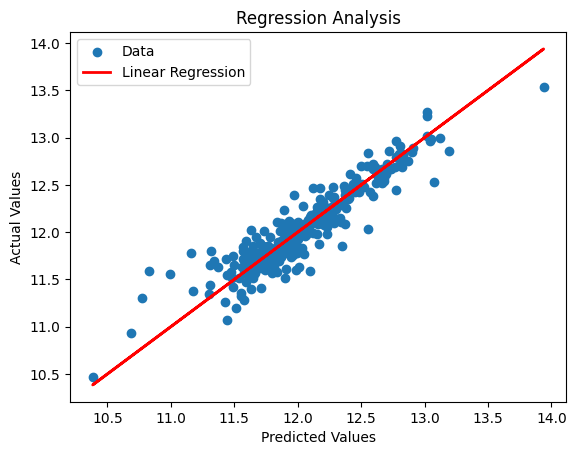

R-squared: 0.8385627429437883
MSE: 0.027579992596784446


In [86]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt

# Create and train the Linear Regression model
linreg = LinearRegression()
linreg.fit(x_train_new, y_train)

# Predict house prices
y_pred = linreg.predict(x_test_new)

# Calculate R-squared and MSE
r2_score = linreg.score(x_test_new, y_test)
mse = metrics.mean_squared_error(y_test, y_pred)

# Visualize the relationship between predicted and actual values
plt.scatter(y_pred, y_test, label='Data')
plt.plot(y_pred, y_pred, color='red', linewidth=2, label='Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend()
plt.title('Regression Analysis')
plt.show()

# Print R-squared and MSE
print("R-squared:", r2_score)
print("MSE:", mse)

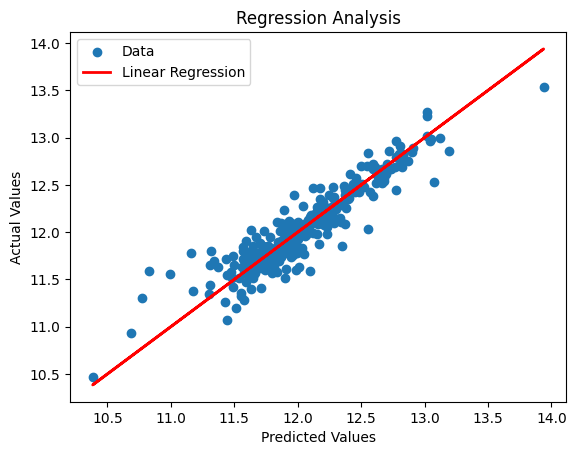

R-squared: 0.8385627429437883
MSE: 0.027579992596784446


In [90]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt

# Create and train the Linear Regression model
linreg = LinearRegression()
linreg.fit(x_train_new, y_train)

# Predict house prices
y_pred = linreg.predict(x_test_new)

# Calculate R-squared and MSE
r2_score = linreg.score(x_test_new, y_test)
mse = metrics.mean_squared_error(y_test, y_pred)

# Visualize the relationship between predicted and actual values
plt.scatter(y_pred, y_test, label='Data')
plt.plot(y_pred, y_pred, color='red', linewidth=2, label='Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend()
plt.title('Regression Analysis')
plt.show()

# Print R-squared and MSE
print("R-squared:", r2_score)
print("MSE:", mse)


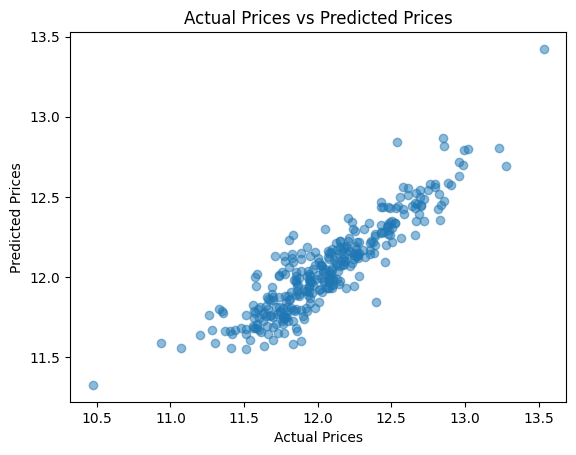

NameError: ignored

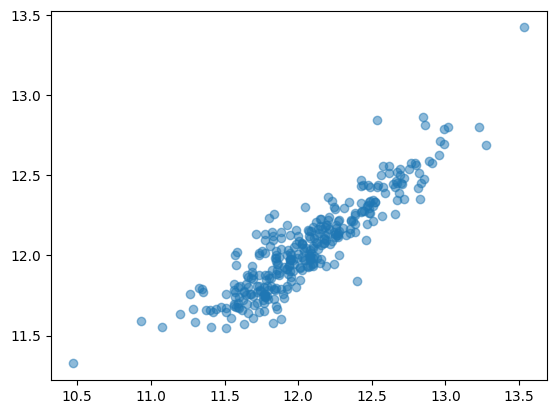

In [107]:
# Import modul yang diperlukan
import matplotlib.pyplot as plt

# Visualisasi nilai prediksi dan aktual
plt.scatter(y_test, y_pred_cv, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Prices vs Predicted Prices")
plt.show()

# Visualisasi prediksi harga baru
plt.scatter(y_test, y_pred_cv, alpha=0.5, label="Actual vs Predicted")
plt.scatter([your_new_feature_value], [y_new_pred[0]], color='red', marker='X', s=100, label='New Prediction')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.title("Actual Prices vs Predicted Prices with New Prediction")
plt.show()



In [88]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# Create and train the Linear Regression model
linreg = LinearRegression()
linreg.fit(x_train_new, y_train)

# Predict house prices
y_pred = linreg.predict(x_test_new)

# Predict a new value
X_new = np.array([[your_new_feature_value]])  # Ganti dengan nilai fitur baru yang ingin diprediksi
y_new_pred = linreg.predict(X_new)

# Calculate R-squared and MSE
r2_score = linreg.score(x_test_new, y_test)
mse = metrics.mean_squared_error(y_test, y_pred)

# Visualize the relationship between predicted and actual values
plt.scatter(y_pred, y_test, label='Data')
plt.plot(y_pred, y_pred, color='red', linewidth=2, label='Linear Regression')
plt.scatter(y_new_pred, your_new_feature_value, color='green', marker='X', s=100, label='Prediksi Harga Baru')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend()
plt.title('Regression Analysis')
plt.show()

# Print R-squared and MSE
print("R-squared:", r2_score)
print("MSE:", mse)
print("Prediksi harga baru:", y_new_pred[0])


NameError: ignored

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt

# Create and train the Linear Regression model
linreg = LinearRegression()
linreg.fit(x_train_new, y_train)

# Predict house prices
y_pred = linreg.predict(x_test_new)

# Predict a new value
X_new = np.array([[your_new_feature_value]])  # Ganti dengan nilai fitur baru yang ingin diprediksi
y_new_pred = linreg.predict(X_new)

# Calculate R-squared and MSE
r2_score = linreg.score(x_test_new, y_test)
mse = metrics.mean_squared_error(y_test, y_pred)

# Visualize the relationship between predicted and actual values
plt.scatter(y_pred, y_test, label='Data')
plt.plot(y_pred, y_pred, color='red', linewidth=2, label='Linear Regression')
plt.scatter(y_new_pred, y_new_pred, color='green', marker='X', s=100, label='Prediksi Harga Baru')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend()
plt.title('Regression Analysis')
plt.show()

# Print R-squared and MSE
print("R-squared:", r2_score)
print("MSE:", mse)
print("Prediksi harga baru:", y_new_pred[0])


NameError: ignored

In [89]:
# Predict a new value
X_new = np.array([[3]])  # Ganti dengan nilai jumlah kamar tidur yang ingin Anda prediksi
y_new_pred = linreg.predict(X_new)


ValueError: ignored

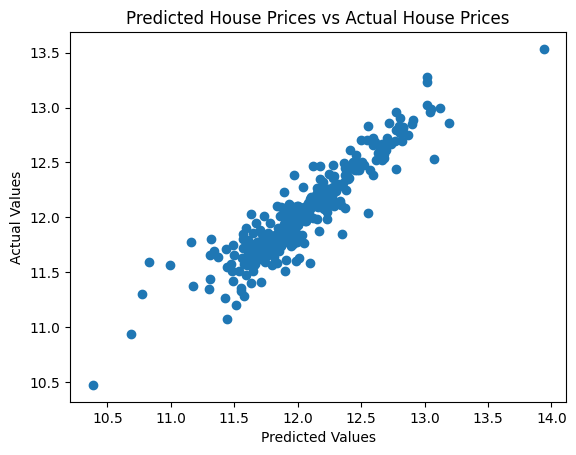

R-squared: 0.8385627429437883
MSE: 0.027579992596784446


In [81]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt

# Create and train the Linear Regression model
linreg = LinearRegression()
linreg.fit(x_train_new, y_train)

# Predict house prices
y_pred = linreg.predict(x_test_new)

# Calculate R-squared and MSE
r2_score = linreg.score(x_test_new, y_test)
mse = metrics.mean_squared_error(y_test, y_pred)

# Visualize the relationship between predicted and actual values
plt.scatter(y_pred, y_test)
plt.title("Predicted House Prices vs Actual House Prices")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

# Print R-squared and MSE
print("R-squared:", r2_score)
print("MSE:", mse)


ValueError: ignored

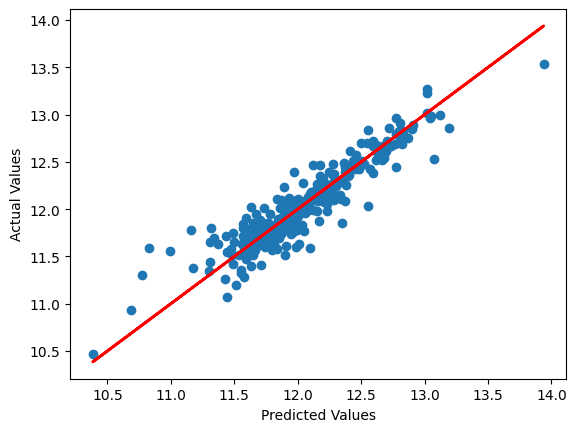

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt

# Create and train the Linear Regression model
linreg = LinearRegression()
linreg.fit(x_train_new, y_train)

# Predict house prices
y_pred = linreg.predict(x_test_new)

# Calculate R-squared and MSE
r2_score = linreg.score(x_test_new, y_test)
mse = metrics.mean_squared_error(y_test, y_pred)

# Visualize the relationship between predicted and actual values
plt.scatter(y_pred, y_test, label='Data')
plt.plot(y_pred, y_pred, color='red', linewidth=2, label='Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Predict a new value
X_new = np.array([[154]])  # Ganti dengan nilai fitur baru yang ingin diprediksi
y_new_pred = linreg.predict(X_new)

# Menambahkan harga yang diprediksi ke dalam visualisasi
plt.scatter(y_new_pred, [154], color='green', marker='X', s=100, label='Prediksi Harga Baru')

plt.legend()
plt.title('Regression Analysis')
plt.show()

# Print R-squared and MSE
print("R-squared:", r2_score)
print("MSE:", mse)
print("Prediksi harga baru:", y_new_pred[0])


In [108]:
import numpy as np

# Kolom 'Predicted_Price' dari data
predicted_prices = data['Predicted_Price']

# Mengonversi kolom 'Predicted_Price' ke dalam bentuk array NumPy
X_new = predicted_prices.values.reshape(-1, 1)

# Sekarang X_new berisi data dari 'Predicted_Price'


KeyError: ignored

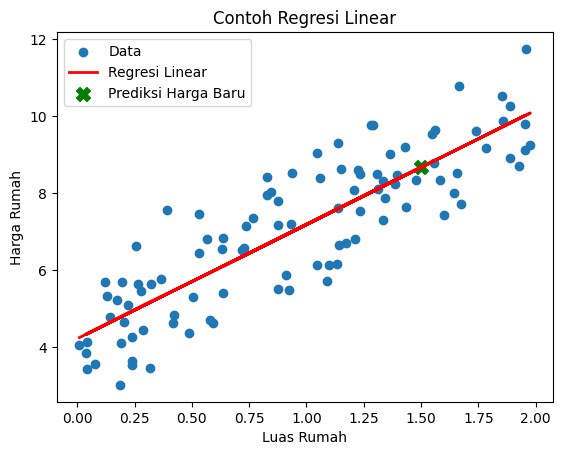

Prediksi harga untuk fitur baru: 8.67485234349876
Nilai R-squared: 0.7469629925504755
MSE: 0.9924386487246479


In [79]:


# Hitung nilai R-squared dan MSE
y_pred_all = model.predict(X)
r2 = r2_score(y, y_pred_all)
mse = mean_squared_error(y, y_pred_all)

# Visualisasi data dan hasil regresi
plt.scatter(X, y, label='Data')
plt.plot(X, y_pred_all, color='red', linewidth=2, label='Regresi Linear')
plt.scatter(X_new, y_pred, color='green', marker='X', s=100, label='Prediksi Harga Baru')
plt.xlabel('Luas Rumah')
plt.ylabel('Harga Rumah')
plt.legend()
plt.title('Contoh Regresi Linear')
plt.show()

# Tampilkan hasil
print(f'Prediksi harga untuk fitur baru: {y_pred[0][0]}')
print(f'Nilai R-squared: {r2}')
print(f'MSE: {mse}')



Our model returns a higher $R^2$ and a relatively low $MSE$, which is good. However there is room for improvement. Let's see which features are most important for our model.

features, reduction of 96.10%


Text(0, 0.5, 'Score %')

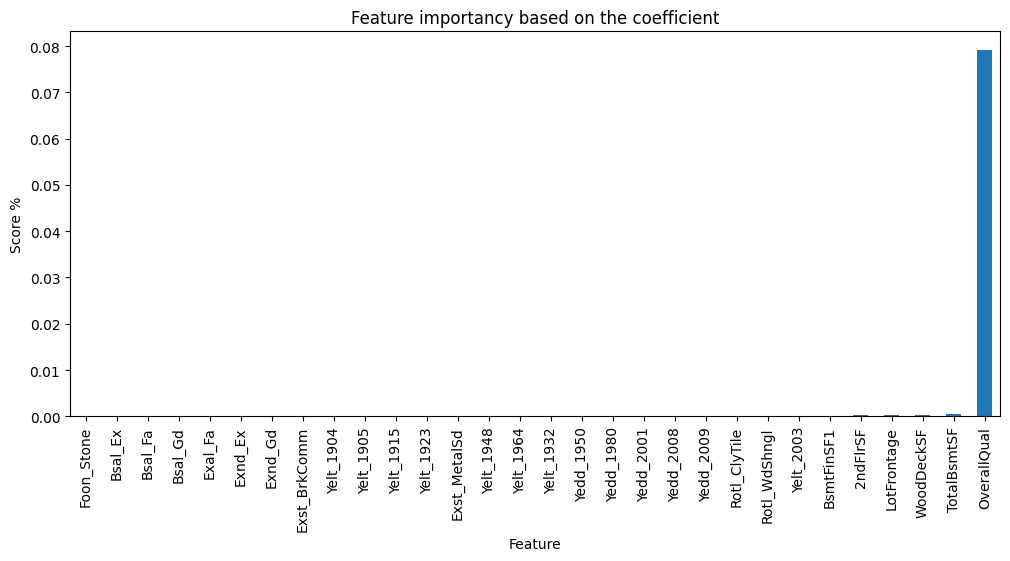

In [73]:
feature_importance = pd.Series(index = x_train_new.columns, data = np.abs(cv_model.coef_))
n_selected_features = (feature_importance>0).sum()
print('features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))
feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (12,5))
plt.title("Feature importancy based on the coefficient")
plt.xlabel("Feature")
plt.ylabel("Score %")

Text(0, 0.5, 'log(Actual Values)')

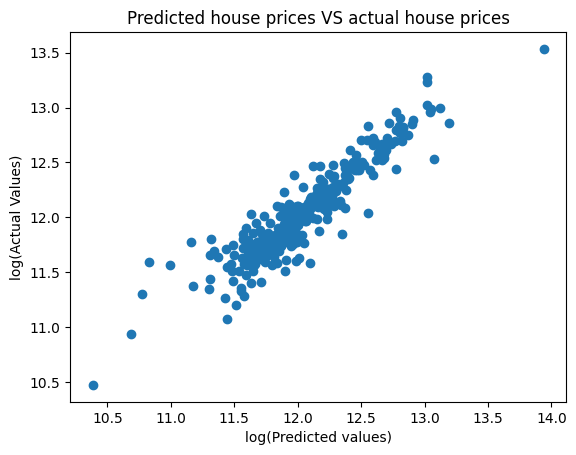

In [74]:
# the relationship between predicted and actual values
pred_y = linreg.predict(x_test_new)
plt.scatter(pred_y,y_test)
plt.title("Predicted house prices VS actual house prices")
plt.xlabel("log(Predicted values)")
plt.ylabel("log(Actual Values)")


In [80]:

plt.title("Predicted House Prices vs Actual House Prices")
plt.xlabel("log(Predicted Values)")
plt.ylabel("log(Actual Values)")
plt.show()


NameError: ignored

The values shown above are log transformations of predicted and actual Sales prices. We can see that our model approximates the prices well. However, there are many improvements that we can make in the model to perform even better. Some of them are,
* Further reducing the feature space by applying techniques such as PCA.
* Try another model other than Linear regression
* Pay more attention to outliers and remove them from the early stage